In [14]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [15]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [16]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        dX = dout @ W.T # vanilla Backprop
#         dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev.copy() # for temporal differencing
#         self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
# #         dy =  dy @ self.W_fixed[2].T # done
#         dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
# #             dy =  dy @ self.W_fixed[2].T # done
#             dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#         dy *= dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [17]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.2883, acc-0.1000, valid loss-2.3073, acc-0.0882, test loss-2.3053, acc-0.0914
Iter-20, train loss-2.3026, acc-0.1000, valid loss-2.3047, acc-0.0930, test loss-2.3028, acc-0.0957
Iter-30, train loss-2.3111, acc-0.1200, valid loss-2.3019, acc-0.0972, test loss-2.3000, acc-0.1007
Iter-40, train loss-2.2832, acc-0.1400, valid loss-2.2992, acc-0.1006, test loss-2.2972, acc-0.1059
Iter-50, train loss-2.2902, acc-0.0600, valid loss-2.2963, acc-0.1060, test loss-2.2943, acc-0.1093
Iter-60, train loss-2.3093, acc-0.0800, valid loss-2.2936, acc-0.1108, test loss-2.2916, acc-0.1149
Iter-70, train loss-2.2783, acc-0.1600, valid loss-2.2910, acc-0.1172, test loss-2.2890, acc-0.1198
Iter-80, train loss-2.2944, acc-0.0600, valid loss-2.2884, acc-0.1216, test loss-2.2864, acc-0.1251
Iter-90, train loss-2.2814, acc-0.1000, valid loss-2.2857, acc-0.1254, test loss-2.2837, acc-0.1286
Iter-100, train loss-2.2866, acc-0.1000, valid loss-2.2831, acc-0.1296, test loss-2.2811, acc-0.1343

Iter-830, train loss-2.1142, acc-0.4600, valid loss-2.0949, acc-0.4920, test loss-2.0932, acc-0.4930
Iter-840, train loss-2.1350, acc-0.4000, valid loss-2.0922, acc-0.4940, test loss-2.0905, acc-0.4947
Iter-850, train loss-2.0984, acc-0.4200, valid loss-2.0898, acc-0.4984, test loss-2.0881, acc-0.4972
Iter-860, train loss-2.0378, acc-0.5600, valid loss-2.0872, acc-0.5006, test loss-2.0855, acc-0.4989
Iter-870, train loss-2.0727, acc-0.5000, valid loss-2.0845, acc-0.5026, test loss-2.0828, acc-0.5011
Iter-880, train loss-2.1090, acc-0.4600, valid loss-2.0820, acc-0.5032, test loss-2.0803, acc-0.5022
Iter-890, train loss-2.0541, acc-0.6000, valid loss-2.0793, acc-0.5066, test loss-2.0777, acc-0.5045
Iter-900, train loss-2.0880, acc-0.5200, valid loss-2.0767, acc-0.5098, test loss-2.0751, acc-0.5066
Iter-910, train loss-2.0480, acc-0.5800, valid loss-2.0741, acc-0.5120, test loss-2.0725, acc-0.5084
Iter-920, train loss-2.0452, acc-0.5800, valid loss-2.0715, acc-0.5130, test loss-2.0699, a

Iter-1640, train loss-1.9045, acc-0.4800, valid loss-1.8842, acc-0.5724, test loss-1.8825, acc-0.5723
Iter-1650, train loss-1.8929, acc-0.5400, valid loss-1.8816, acc-0.5726, test loss-1.8800, acc-0.5732
Iter-1660, train loss-1.9554, acc-0.5600, valid loss-1.8790, acc-0.5724, test loss-1.8774, acc-0.5729
Iter-1670, train loss-1.8729, acc-0.6000, valid loss-1.8763, acc-0.5722, test loss-1.8747, acc-0.5737
Iter-1680, train loss-1.9087, acc-0.5600, valid loss-1.8737, acc-0.5728, test loss-1.8720, acc-0.5746
Iter-1690, train loss-1.8958, acc-0.5400, valid loss-1.8712, acc-0.5742, test loss-1.8696, acc-0.5767
Iter-1700, train loss-1.9038, acc-0.5400, valid loss-1.8685, acc-0.5736, test loss-1.8669, acc-0.5773
Iter-1710, train loss-1.7941, acc-0.6600, valid loss-1.8659, acc-0.5746, test loss-1.8642, acc-0.5778
Iter-1720, train loss-1.8725, acc-0.5400, valid loss-1.8632, acc-0.5754, test loss-1.8616, acc-0.5775
Iter-1730, train loss-1.8550, acc-0.5600, valid loss-1.8606, acc-0.5764, test loss

Iter-2450, train loss-1.6667, acc-0.6800, valid loss-1.6745, acc-0.6182, test loss-1.6731, acc-0.6176
Iter-2460, train loss-1.7160, acc-0.5800, valid loss-1.6719, acc-0.6186, test loss-1.6706, acc-0.6176
Iter-2470, train loss-1.6749, acc-0.6600, valid loss-1.6694, acc-0.6192, test loss-1.6681, acc-0.6182
Iter-2480, train loss-1.7293, acc-0.5800, valid loss-1.6668, acc-0.6198, test loss-1.6655, acc-0.6192
Iter-2490, train loss-1.6249, acc-0.6400, valid loss-1.6643, acc-0.6204, test loss-1.6630, acc-0.6189
Iter-2500, train loss-1.7588, acc-0.5400, valid loss-1.6618, acc-0.6214, test loss-1.6605, acc-0.6191
Iter-2510, train loss-1.6540, acc-0.6600, valid loss-1.6592, acc-0.6216, test loss-1.6579, acc-0.6195
Iter-2520, train loss-1.6222, acc-0.7200, valid loss-1.6567, acc-0.6222, test loss-1.6554, acc-0.6191
Iter-2530, train loss-1.6437, acc-0.6400, valid loss-1.6543, acc-0.6226, test loss-1.6530, acc-0.6193
Iter-2540, train loss-1.6892, acc-0.5400, valid loss-1.6518, acc-0.6224, test loss

Iter-3260, train loss-1.5185, acc-0.6600, valid loss-1.4792, acc-0.6834, test loss-1.4798, acc-0.6661
Iter-3270, train loss-1.4931, acc-0.6000, valid loss-1.4770, acc-0.6850, test loss-1.4776, acc-0.6666
Iter-3280, train loss-1.4347, acc-0.7400, valid loss-1.4748, acc-0.6856, test loss-1.4754, acc-0.6674
Iter-3290, train loss-1.5035, acc-0.6400, valid loss-1.4727, acc-0.6862, test loss-1.4732, acc-0.6681
Iter-3300, train loss-1.5652, acc-0.6000, valid loss-1.4704, acc-0.6866, test loss-1.4710, acc-0.6686
Iter-3310, train loss-1.4441, acc-0.6600, valid loss-1.4680, acc-0.6872, test loss-1.4687, acc-0.6691
Iter-3320, train loss-1.5187, acc-0.6600, valid loss-1.4658, acc-0.6876, test loss-1.4665, acc-0.6698
Iter-3330, train loss-1.4217, acc-0.7200, valid loss-1.4635, acc-0.6890, test loss-1.4642, acc-0.6703
Iter-3340, train loss-1.5400, acc-0.5600, valid loss-1.4613, acc-0.6886, test loss-1.4620, acc-0.6714
Iter-3350, train loss-1.4056, acc-0.7000, valid loss-1.4591, acc-0.6892, test loss

Iter-4070, train loss-1.4712, acc-0.6600, valid loss-1.3077, acc-0.7222, test loss-1.3101, acc-0.7201
Iter-4080, train loss-1.3308, acc-0.6400, valid loss-1.3058, acc-0.7224, test loss-1.3082, acc-0.7195
Iter-4090, train loss-1.4593, acc-0.6200, valid loss-1.3038, acc-0.7224, test loss-1.3062, acc-0.7194
Iter-4100, train loss-1.4940, acc-0.6200, valid loss-1.3019, acc-0.7230, test loss-1.3043, acc-0.7194
Iter-4110, train loss-1.2628, acc-0.7200, valid loss-1.2999, acc-0.7222, test loss-1.3024, acc-0.7192
Iter-4120, train loss-1.2938, acc-0.7600, valid loss-1.2980, acc-0.7218, test loss-1.3005, acc-0.7185
Iter-4130, train loss-1.3580, acc-0.6400, valid loss-1.2960, acc-0.7230, test loss-1.2986, acc-0.7191
Iter-4140, train loss-1.3543, acc-0.6600, valid loss-1.2942, acc-0.7238, test loss-1.2968, acc-0.7201
Iter-4150, train loss-1.3983, acc-0.7800, valid loss-1.2922, acc-0.7244, test loss-1.2949, acc-0.7209
Iter-4160, train loss-1.2720, acc-0.7600, valid loss-1.2902, acc-0.7248, test loss

Iter-4880, train loss-1.2003, acc-0.7600, valid loss-1.1633, acc-0.7554, test loss-1.1678, acc-0.7552
Iter-4890, train loss-1.0813, acc-0.8200, valid loss-1.1617, acc-0.7556, test loss-1.1662, acc-0.7560
Iter-4900, train loss-1.0821, acc-0.7800, valid loss-1.1601, acc-0.7564, test loss-1.1645, acc-0.7563
Iter-4910, train loss-1.1415, acc-0.7400, valid loss-1.1585, acc-0.7572, test loss-1.1630, acc-0.7566
Iter-4920, train loss-1.1403, acc-0.7400, valid loss-1.1568, acc-0.7570, test loss-1.1614, acc-0.7563
Iter-4930, train loss-1.1124, acc-0.7800, valid loss-1.1552, acc-0.7570, test loss-1.1598, acc-0.7565
Iter-4940, train loss-1.3750, acc-0.6200, valid loss-1.1536, acc-0.7572, test loss-1.1583, acc-0.7573
Iter-4950, train loss-1.1057, acc-0.8400, valid loss-1.1520, acc-0.7576, test loss-1.1567, acc-0.7573
Iter-4960, train loss-1.1180, acc-0.7200, valid loss-1.1504, acc-0.7580, test loss-1.1551, acc-0.7579
Iter-4970, train loss-1.1439, acc-0.8200, valid loss-1.1488, acc-0.7584, test loss

Iter-5690, train loss-1.1882, acc-0.6400, valid loss-1.0449, acc-0.7820, test loss-1.0508, acc-0.7787
Iter-5700, train loss-1.0720, acc-0.7400, valid loss-1.0436, acc-0.7826, test loss-1.0495, acc-0.7792
Iter-5710, train loss-1.1782, acc-0.7800, valid loss-1.0422, acc-0.7826, test loss-1.0482, acc-0.7792
Iter-5720, train loss-1.1509, acc-0.7800, valid loss-1.0410, acc-0.7828, test loss-1.0470, acc-0.7796
Iter-5730, train loss-0.9452, acc-0.8400, valid loss-1.0396, acc-0.7828, test loss-1.0456, acc-0.7802
Iter-5740, train loss-1.0314, acc-0.7800, valid loss-1.0384, acc-0.7830, test loss-1.0443, acc-0.7807
Iter-5750, train loss-0.8605, acc-0.9000, valid loss-1.0371, acc-0.7828, test loss-1.0430, acc-0.7809
Iter-5760, train loss-1.0165, acc-0.7200, valid loss-1.0359, acc-0.7826, test loss-1.0418, acc-0.7808
Iter-5770, train loss-1.1373, acc-0.7000, valid loss-1.0346, acc-0.7822, test loss-1.0406, acc-0.7812
Iter-5780, train loss-1.0394, acc-0.8400, valid loss-1.0333, acc-0.7828, test loss

Iter-6500, train loss-1.0165, acc-0.7600, valid loss-0.9483, acc-0.8026, test loss-0.9546, acc-0.8000
Iter-6510, train loss-0.8835, acc-0.8200, valid loss-0.9472, acc-0.8038, test loss-0.9536, acc-0.7999
Iter-6520, train loss-0.9566, acc-0.8000, valid loss-0.9462, acc-0.8042, test loss-0.9525, acc-0.8006
Iter-6530, train loss-0.9519, acc-0.8200, valid loss-0.9451, acc-0.8042, test loss-0.9515, acc-0.8006
Iter-6540, train loss-1.1157, acc-0.7800, valid loss-0.9441, acc-0.8032, test loss-0.9504, acc-0.8008
Iter-6550, train loss-1.0606, acc-0.8200, valid loss-0.9431, acc-0.8038, test loss-0.9494, acc-0.8014
Iter-6560, train loss-0.8909, acc-0.8000, valid loss-0.9420, acc-0.8042, test loss-0.9483, acc-0.8013
Iter-6570, train loss-0.8424, acc-0.9000, valid loss-0.9409, acc-0.8044, test loss-0.9472, acc-0.8016
Iter-6580, train loss-0.9992, acc-0.8400, valid loss-0.9399, acc-0.8044, test loss-0.9462, acc-0.8019
Iter-6590, train loss-0.9252, acc-0.7800, valid loss-0.9389, acc-0.8048, test loss

Iter-7310, train loss-0.8253, acc-0.8600, valid loss-0.8689, acc-0.8192, test loss-0.8759, acc-0.8168
Iter-7320, train loss-0.9199, acc-0.7600, valid loss-0.8680, acc-0.8194, test loss-0.8749, acc-0.8170
Iter-7330, train loss-0.8710, acc-0.8200, valid loss-0.8671, acc-0.8194, test loss-0.8740, acc-0.8176
Iter-7340, train loss-1.0477, acc-0.6800, valid loss-0.8662, acc-0.8200, test loss-0.8730, acc-0.8176
Iter-7350, train loss-0.8088, acc-0.8000, valid loss-0.8653, acc-0.8200, test loss-0.8721, acc-0.8175
Iter-7360, train loss-0.8233, acc-0.8400, valid loss-0.8645, acc-0.8198, test loss-0.8713, acc-0.8174
Iter-7370, train loss-0.9900, acc-0.7000, valid loss-0.8635, acc-0.8198, test loss-0.8704, acc-0.8177
Iter-7380, train loss-0.9129, acc-0.7400, valid loss-0.8627, acc-0.8200, test loss-0.8695, acc-0.8182
Iter-7390, train loss-1.0709, acc-0.7200, valid loss-0.8619, acc-0.8202, test loss-0.8687, acc-0.8183
Iter-7400, train loss-0.8595, acc-0.8600, valid loss-0.8610, acc-0.8200, test loss

Iter-8120, train loss-0.6728, acc-0.9400, valid loss-0.8031, acc-0.8308, test loss-0.8099, acc-0.8304
Iter-8130, train loss-0.8874, acc-0.8200, valid loss-0.8024, acc-0.8304, test loss-0.8091, acc-0.8304
Iter-8140, train loss-1.0689, acc-0.6800, valid loss-0.8017, acc-0.8310, test loss-0.8084, acc-0.8307
Iter-8150, train loss-0.8661, acc-0.8200, valid loss-0.8009, acc-0.8314, test loss-0.8076, acc-0.8310
Iter-8160, train loss-0.9360, acc-0.7800, valid loss-0.8001, acc-0.8320, test loss-0.8068, acc-0.8312
Iter-8170, train loss-0.7775, acc-0.8600, valid loss-0.7994, acc-0.8324, test loss-0.8061, acc-0.8314
Iter-8180, train loss-0.6585, acc-0.9200, valid loss-0.7988, acc-0.8328, test loss-0.8053, acc-0.8318
Iter-8190, train loss-0.9286, acc-0.7000, valid loss-0.7981, acc-0.8334, test loss-0.8045, acc-0.8318
Iter-8200, train loss-0.7872, acc-0.8200, valid loss-0.7974, acc-0.8336, test loss-0.8038, acc-0.8323
Iter-8210, train loss-0.8931, acc-0.7600, valid loss-0.7967, acc-0.8334, test loss

Iter-8930, train loss-0.7610, acc-0.7600, valid loss-0.7478, acc-0.8434, test loss-0.7544, acc-0.8385
Iter-8940, train loss-0.7816, acc-0.8000, valid loss-0.7471, acc-0.8440, test loss-0.7538, acc-0.8384
Iter-8950, train loss-0.7383, acc-0.8800, valid loss-0.7466, acc-0.8438, test loss-0.7532, acc-0.8385
Iter-8960, train loss-0.7084, acc-0.9000, valid loss-0.7459, acc-0.8438, test loss-0.7526, acc-0.8383
Iter-8970, train loss-0.7554, acc-0.8600, valid loss-0.7452, acc-0.8440, test loss-0.7519, acc-0.8388
Iter-8980, train loss-0.9486, acc-0.8200, valid loss-0.7446, acc-0.8442, test loss-0.7513, acc-0.8387
Iter-8990, train loss-0.5906, acc-0.9000, valid loss-0.7440, acc-0.8440, test loss-0.7507, acc-0.8386
Iter-9000, train loss-0.6254, acc-0.8800, valid loss-0.7434, acc-0.8442, test loss-0.7501, acc-0.8389
Iter-9010, train loss-0.7562, acc-0.8000, valid loss-0.7427, acc-0.8442, test loss-0.7496, acc-0.8390
Iter-9020, train loss-0.6574, acc-0.8800, valid loss-0.7422, acc-0.8444, test loss

Iter-9740, train loss-0.6983, acc-0.8400, valid loss-0.7010, acc-0.8526, test loss-0.7076, acc-0.8467
Iter-9750, train loss-0.6537, acc-0.9000, valid loss-0.7004, acc-0.8526, test loss-0.7070, acc-0.8469
Iter-9760, train loss-0.7177, acc-0.8800, valid loss-0.6999, acc-0.8528, test loss-0.7065, acc-0.8471
Iter-9770, train loss-0.5728, acc-0.9000, valid loss-0.6993, acc-0.8526, test loss-0.7059, acc-0.8468
Iter-9780, train loss-0.8296, acc-0.7800, valid loss-0.6988, acc-0.8530, test loss-0.7054, acc-0.8470
Iter-9790, train loss-0.7892, acc-0.8400, valid loss-0.6983, acc-0.8538, test loss-0.7049, acc-0.8472
Iter-9800, train loss-0.7347, acc-0.8400, valid loss-0.6977, acc-0.8538, test loss-0.7043, acc-0.8471
Iter-9810, train loss-0.8348, acc-0.7400, valid loss-0.6972, acc-0.8536, test loss-0.7038, acc-0.8472
Iter-9820, train loss-0.7345, acc-0.8400, valid loss-0.6967, acc-0.8536, test loss-0.7033, acc-0.8469
Iter-9830, train loss-0.8791, acc-0.7600, valid loss-0.6962, acc-0.8538, test loss

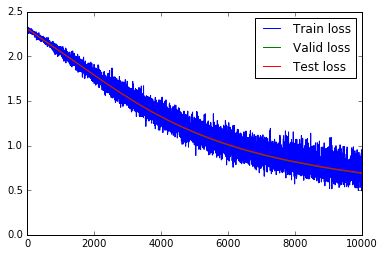

In [18]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

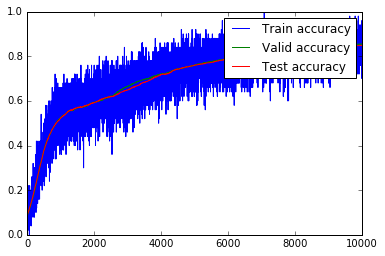

In [19]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()